# E.ON Future Lab - Day Ahead Electricity Price Forecasting

## Background
You are in control of a fleet of batteries and wish to operate the batteries in the optimal way to make a profit. As part of your operations, it is ideal if
you can predict the day ahead electricity prices before they are published. Day-ahead electricity prices in Europe are the prices at which electricity is
bought and sold a day before it is actually consumed. These prices help market participants plan their electricity production and consumption based on
anticipated supply and demand, as well as other factors like weather conditions and regulations.
Day-ahead electricity prices for day D, are determined through an auction process and are typically published on the previous day, D-1. The prices are
usually made available around midday to provide market participants with sufficient time to plan their electricity activities for the upcoming day.
By predicting the day-ahead electricity prices before the auction takes place you can gain an advantage. It would enable you to make informed
decisions regarding trading strategies, potentially leading to improved profitability and better utilization of your battery fleet.

## Modeling Task

Your task is to develop a predictive model that forecasts day-ahead electricity prices in the Germany -LU region. The model should utilize historical
data and weather information.
You can access get data about prices, energy production and consumption from the ENTSOE transparency https://transparency.entsoe.eu/
The data can be accessed through this python library: https://pypi.org/project/entsoe-py/0.2.2/ and the provided token.
From the ENTSOE website you will have access to:
Actual load data, Load forecast data, Actual generation data, Generation forecast data, Wind and solar generation forecast
When predicting the day ahead prices for day D, only the actual load and generation data for day D-2, will be available, this should be taken into
account during pre-processing. The available load and generation forecast will include values up to day D. The ENTSOE service contains many
different data columns. For this task only use load and generation data, ignore transmission, etc.
You should use data from 01.01.2023 to up and including the 01.06.23 for training and validation.
Weather data for Berlin, Frankfurt and Munich can also be used in the models, it can accessed with https://pypi.org/project/dwdweather2/ or
alternative.

# Table of Contents
1. Exploration and Cleaning
    1. Load Datasets
        * Energy Data
        * Weather Data
    2. Merge Energy and Weather Datasets 
 
2. Visualization and Analysis
    1. Useful Visualizations
    2. Stationary Tests
    3. Auto Correlation, Partial Auto Correlation and Cross-Corelation

3. Feature Engineering
    1. Feature Generation
    2. Feature Selection

4. Modeling 
    1. XGBoost
    2. LSTM
    3. CNN
    4. CNN-LSTM
    5. Time Distributed MLP 

5. Evaluation

In [197]:
import logging
import time
from contextlib import contextmanager
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import multiprocessing_logging
from src.utils._get_data import DataHandler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
# import statsmodels.api as sm
# import tensorflow as tf
# import xgboost as xgb
# import warnings
# from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller, kpss, ccf
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
from math import sqrt
pd.options.display.max_columns = None
%matplotlib inline
# after setting up your logger
logging.basicConfig(level=logging.INFO)
multiprocessing_logging.install_mp_handler()

In [198]:
# Create a context manager for timing sections of code
@contextmanager
def log_time(section_name: str):
    """
    Context manager for timing sections of your code. 
    It logs completion time on successful completion of the with block.
    """
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info(f"{section_name} completed in {elapsed_time} seconds")


# 1. Exploration and Cleaning

We have different datasets that contain load and generation and day ahead electricy prices information. Additionaly we have historical weather data for the following cities : Munich, Berlin, FRankfurt between the dates 01.01.2023 and 01.06.2023

## 1.1. Load Datasets
Please see the DataHandler class from the following path for detailed implementation
* `src.utils._get_data.py -> DataHandler()`

In [199]:
# Describe the data you want to get
data_names = [
    'load_data',
    #'load_forecast',
    'generation_data',
    #'generation_forecast',
    #'wind_and_solar_forecast',
    'day_ahead_prices',
    'weather_data'
]

# Describe the country code, start and end dates
country_code = 'DE_LU'
start = pd.Timestamp('2022-12-01', tz='Europe/Berlin')
end = pd.Timestamp('2023-06-01', tz='Europe/Berlin')

In [200]:
# Added multiprocessing to speed up the data loading process

# function to load a single dataset
def load_single_dataset(args):
    dataset_name, data_handler = args
    try:
        with log_time(dataset_name):
            df = data_handler._get_data(dataset_name)
            logging.info(f"{dataset_name} data retrieved successfully")
            return dataset_name, df
    except Exception as e:
        logging.error(f"Error while loading {dataset_name}: {e}")
        raise e

def load_dataset():
    df_dict = {} # Dictionary to store the dataframes
    try:
        with log_time("DataHandler"):
            data_handler = DataHandler()
            logging.info("DataHandler object created successfully")
            data_handler._set_data_settings(country_code, start, end)
            logging.info("DataHandler settings set successfully")
            with Pool(cpu_count()) as pool:
                results = pool.map(load_single_dataset, [(name, data_handler) for name in data_names])
            for dataset_name, df in results:
                df_dict[dataset_name] = df
    except Exception as e:
        logging.error(f"Error while creating DataHandler: {e}")
        raise e

    return df_dict

In [201]:
df_dict = load_dataset()

INFO:root:DataHandler object created successfully
INFO:root:DataHandler settings set successfully


/home/mamur/EON/forecast-electricity-prices/src/utils/_get_data.py:80: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(self.weather_data_path, index_col=0, parse_dates=True)
INFO:root:weather_data data retrieved successfully
INFO:root:weather_data completed in 0.06395411491394043 seconds
INFO:root:load_data data retrieved successfully
INFO:root:load_data completed in 3.6952383518218994 seconds
INFO:root:day_ahead_prices data retrieved successfully
INFO:root:day_ahead_prices completed in 8.696362018585205 seconds
INFO:root:generation_data data retrieved successfully
INFO:root:generation_data completed in 65.02691674232483 seconds
INFO:root:DataHandler completed in 65.2707769870758 seconds


In [61]:
# Prin the type of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {type(df)}")

load_data: <class 'pandas.core.frame.DataFrame'>
generation_data: <class 'pandas.core.frame.DataFrame'>
day_ahead_prices: <class 'pandas.core.frame.DataFrame'>
weather_data: <class 'pandas.core.frame.DataFrame'>


### 1.1.1 Energy Dataset

In [122]:
energy_datasets = ['load_data', 'load_forecast', 'generation_data', 'generation_forecast', 'wind_and_solar_forecast', 'day_ahead_prices']

In [123]:
# print the columns of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.columns}")

load_data: Index(['Actual Load'], dtype='object')
generation_data: MultiIndex([(                        'Biomass',  'Actual Aggregated'),
            (      'Fossil Brown coal/Lignite',  'Actual Aggregated'),
            (                     'Fossil Gas',  'Actual Aggregated'),
            (               'Fossil Hard coal',  'Actual Aggregated'),
            (                     'Fossil Oil',  'Actual Aggregated'),
            (                     'Geothermal',  'Actual Aggregated'),
            (           'Hydro Pumped Storage',  'Actual Aggregated'),
            (           'Hydro Pumped Storage', 'Actual Consumption'),
            ('Hydro Run-of-river and poundage',  'Actual Aggregated'),
            (          'Hydro Water Reservoir',  'Actual Aggregated'),
            (                        'Nuclear',  'Actual Aggregated'),
            (                          'Other',  'Actual Aggregated'),
            (                'Other renewable',  'Actual Aggregated'),
          

In [124]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.index.freq} {len(df)}")

load_data: <15 * Minutes> 17468
generation_data: <15 * Minutes> 17468
day_ahead_prices: <60 * Minutes> 4368


Since our target variable has a hourly frequency we can resample others to have hourly frequency also

In [125]:
# resample the data to hourly frequency
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        df_dict[dataset_name] = df.resample('H').mean()


In [126]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.index.freq} {len(df)}")

load_data: <Hour> 4367
generation_data: <Hour> 4367
day_ahead_prices: <Hour> 4368


In [127]:
# print the data types of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.dtypes}")

load_data: Actual Load    float64
dtype: object
generation_data: Biomass                          Actual Aggregated     float64
Fossil Brown coal/Lignite        Actual Aggregated     float64
Fossil Gas                       Actual Aggregated     float64
Fossil Hard coal                 Actual Aggregated     float64
Fossil Oil                       Actual Aggregated     float64
Geothermal                       Actual Aggregated     float64
Hydro Pumped Storage             Actual Aggregated     float64
                                 Actual Consumption    float64
Hydro Run-of-river and poundage  Actual Aggregated     float64
Hydro Water Reservoir            Actual Aggregated     float64
Nuclear                          Actual Aggregated     float64
Other                            Actual Aggregated     float64
Other renewable                  Actual Aggregated     float64
Solar                            Actual Aggregated     float64
                                 Actual Consumption  

As we can see, all variables are numeric (float64)

Now we can merge all energy datasets and get started with the exploration and cleaning procedure

In [128]:
df_energy_all = pd.concat([df_dict['load_data'], df_dict['generation_data'], df_dict['day_ahead_prices']], axis=1)

In [129]:
start_date = '2023-01-01'
df_energy= df_energy_all[df_energy_all.index >= start_date]

In [130]:
df_energy.head()

,Actual Load,"(Biomass, Actual Aggregated)","(Fossil Brown coal/Lignite, Actual Aggregated)","(Fossil Gas, Actual Aggregated)","(Fossil Hard coal, Actual Aggregated)","(Fossil Oil, Actual Aggregated)","(Geothermal, Actual Aggregated)","(Hydro Pumped Storage, Actual Aggregated)","(Hydro Pumped Storage, Actual Consumption)","(Hydro Run-of-river and poundage, Actual Aggregated)","(Hydro Water Reservoir, Actual Aggregated)","(Nuclear, Actual Aggregated)","(Other, Actual Aggregated)","(Other renewable, Actual Aggregated)","(Solar, Actual Aggregated)","(Solar, Actual Consumption)","(Waste, Actual Aggregated)","(Wind Offshore, Actual Aggregated)","(Wind Onshore, Actual Aggregated)","(Wind Onshore, Actual Consumption)",day_ahead_price
2023-01-01 00:00:00+01:00,38931.75,NaN,3859.25,2469.00,2067.50,8.0,26.50,42.75,1933.50,1215.00,82.00,2459.50,187.0,103.0,0.0,0.0,747.75,3059.25,28752.25,0.0,-5.17
2023-01-01 01:00:00+01:00,38314.00,NaN,3866.50,2292.25,2052.00,8.0,26.00,172.50,2025.50,1212.50,36.25,2458.75,187.0,103.0,0.0,0.0,737.75,3586.00,29348.00,0.0,-1.07
2023-01-01 02:00:00+01:00,37470.25,NaN,3860.25,2240.50,2034.25,8.0,26.00,163.50,3636.75,1211.00,33.50,2459.75,187.0,103.0,0.0,0.0,731.25,3842.25,29311.50,0.0,-1.47
2023-01-01 03:00:00+01:00,36497.75,NaN,3864.75,2243.75,2037.00,8.0,26.00,161.00,4385.50,1208.75,36.50,2460.50,187.0,103.0,0.0,0.0,731.75,3463.25,27053.75,0.0,-5.08
2023-01-01 04:00:00+01:00,36065.00,NaN,3841.00,2254.75,2040.25,8.0,25.25,160.50,4411.50,1204.25,61.75,2461.00,187.0,103.0,0.0,0.0,734.25,3462.25,26481.00,0.0,-4.49


In [131]:
df_energy.describe().round(2)

,Actual Load,"(Biomass, Actual Aggregated)","(Fossil Brown coal/Lignite, Actual Aggregated)","(Fossil Gas, Actual Aggregated)","(Fossil Hard coal, Actual Aggregated)","(Fossil Oil, Actual Aggregated)","(Geothermal, Actual Aggregated)","(Hydro Pumped Storage, Actual Aggregated)","(Hydro Pumped Storage, Actual Consumption)","(Hydro Run-of-river and poundage, Actual Aggregated)","(Hydro Water Reservoir, Actual Aggregated)","(Nuclear, Actual Aggregated)","(Other, Actual Aggregated)","(Other renewable, Actual Aggregated)","(Solar, Actual Aggregated)","(Solar, Actual Consumption)","(Waste, Actual Aggregated)","(Wind Offshore, Actual Aggregated)","(Wind Onshore, Actual Aggregated)","(Wind Onshore, Actual Consumption)",day_ahead_price
count,3623.00,3335.00,3623.00,3623.00,3623.00,3623.00,3623.00,3623.00,3623.00,3623.00,3623.00,2991.00,3623.00,3623.00,3623.00,3623.0,3623.00,3623.00,3623.00,3623.0,3624.00
mean,55028.61,4679.21,9731.93,6134.50,5684.60,68.02,24.71,1381.95,1751.92,1387.92,92.54,2253.67,231.18,127.10,5605.71,0.0,762.26,2791.88,14415.24,0.0,105.82
std,8663.51,200.08,3597.48,2901.14,3846.52,115.03,3.63,1797.60,2070.96,297.14,64.29,1018.45,52.44,23.41,8906.23,0.0,95.87,1794.90,10455.28,0.0,46.37
min,35314.50,4227.00,3157.75,1936.50,994.50,8.00,15.00,0.00,0.00,976.50,3.75,0.00,125.00,85.00,0.00,0.0,319.00,0.00,230.00,0.0,-129.96
25%,47797.75,4527.75,6745.38,3989.62,2352.88,8.00,22.00,191.62,222.88,1166.75,42.38,2133.50,191.00,107.62,0.00,0.0,706.75,1166.12,6184.62,0.0,84.02
50%,54865.50,4659.00,9540.00,5401.00,4702.25,8.00,23.50,521.25,728.75,1282.75,75.75,2700.50,230.50,127.00,119.00,0.0,790.25,2716.50,11817.50,0.0,106.84
75%,62575.88,4812.38,12879.38,7600.00,7961.00,34.38,28.00,1845.25,2750.00,1492.00,127.00,2914.00,268.12,144.12,8521.25,0.0,834.75,4208.12,20400.25,0.0,133.98
max,72296.50,5190.25,16450.75,16111.75,15240.50,564.25,32.00,9163.00,8420.50,2079.00,403.75,3082.25,349.00,175.00,40746.25,0.0,908.00,7633.50,45430.50,0.0,270.22


We will drop all the columns that are constituted by zeroes, as they are unusable. 

In [132]:
# Create a list of column labels to drop
columns_to_drop = [('Solar', 'Actual Consumption'), ('Wind Onshore', 'Actual Consumption')]
# Drop the specified columns
df_energy = df_energy.drop(columns_to_drop, axis=1)


In [133]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3624 entries, 2023-01-01 00:00:00+01:00 to 2023-06-01 00:00:00+02:00
Freq: H
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Actual Load                                           3623 non-null   float64
 1   (Biomass, Actual Aggregated)                          3335 non-null   float64
 2   (Fossil Brown coal/Lignite, Actual Aggregated)        3623 non-null   float64
 3   (Fossil Gas, Actual Aggregated)                       3623 non-null   float64
 4   (Fossil Hard coal, Actual Aggregated)                 3623 non-null   float64
 5   (Fossil Oil, Actual Aggregated)                       3623 non-null   float64
 6   (Geothermal, Actual Aggregated)                       3623 non-null   float64
 7   (Hydro Pumped Storage, Actual Aggregated)             3623 non-null   float64
 8   (H

In [134]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 938 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [135]:
df_energy.isna().sum()

Actual Load                                               1
(Biomass, Actual Aggregated)                            289
(Fossil Brown coal/Lignite, Actual Aggregated)            1
(Fossil Gas, Actual Aggregated)                           1
(Fossil Hard coal, Actual Aggregated)                     1
(Fossil Oil, Actual Aggregated)                           1
(Geothermal, Actual Aggregated)                           1
(Hydro Pumped Storage, Actual Aggregated)                 1
(Hydro Pumped Storage, Actual Consumption)                1
(Hydro Run-of-river and poundage, Actual Aggregated)      1
(Hydro Water Reservoir, Actual Aggregated)                1
(Nuclear, Actual Aggregated)                            633
(Other, Actual Aggregated)                                1
(Other renewable, Actual Aggregated)                      1
(Solar, Actual Aggregated)                                1
(Waste, Actual Aggregated)                                1
(Wind Offshore, Actual Aggregated)      

As we can see, there are some missing values in Biomass and Nuclear columns. Therefore its a good idea to visualize and see if we can do something for them 

In [136]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        if end is not None:
            ax.plot(df[column][start:end], label=label)
        else:
            ax.plot(df[column][start:], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

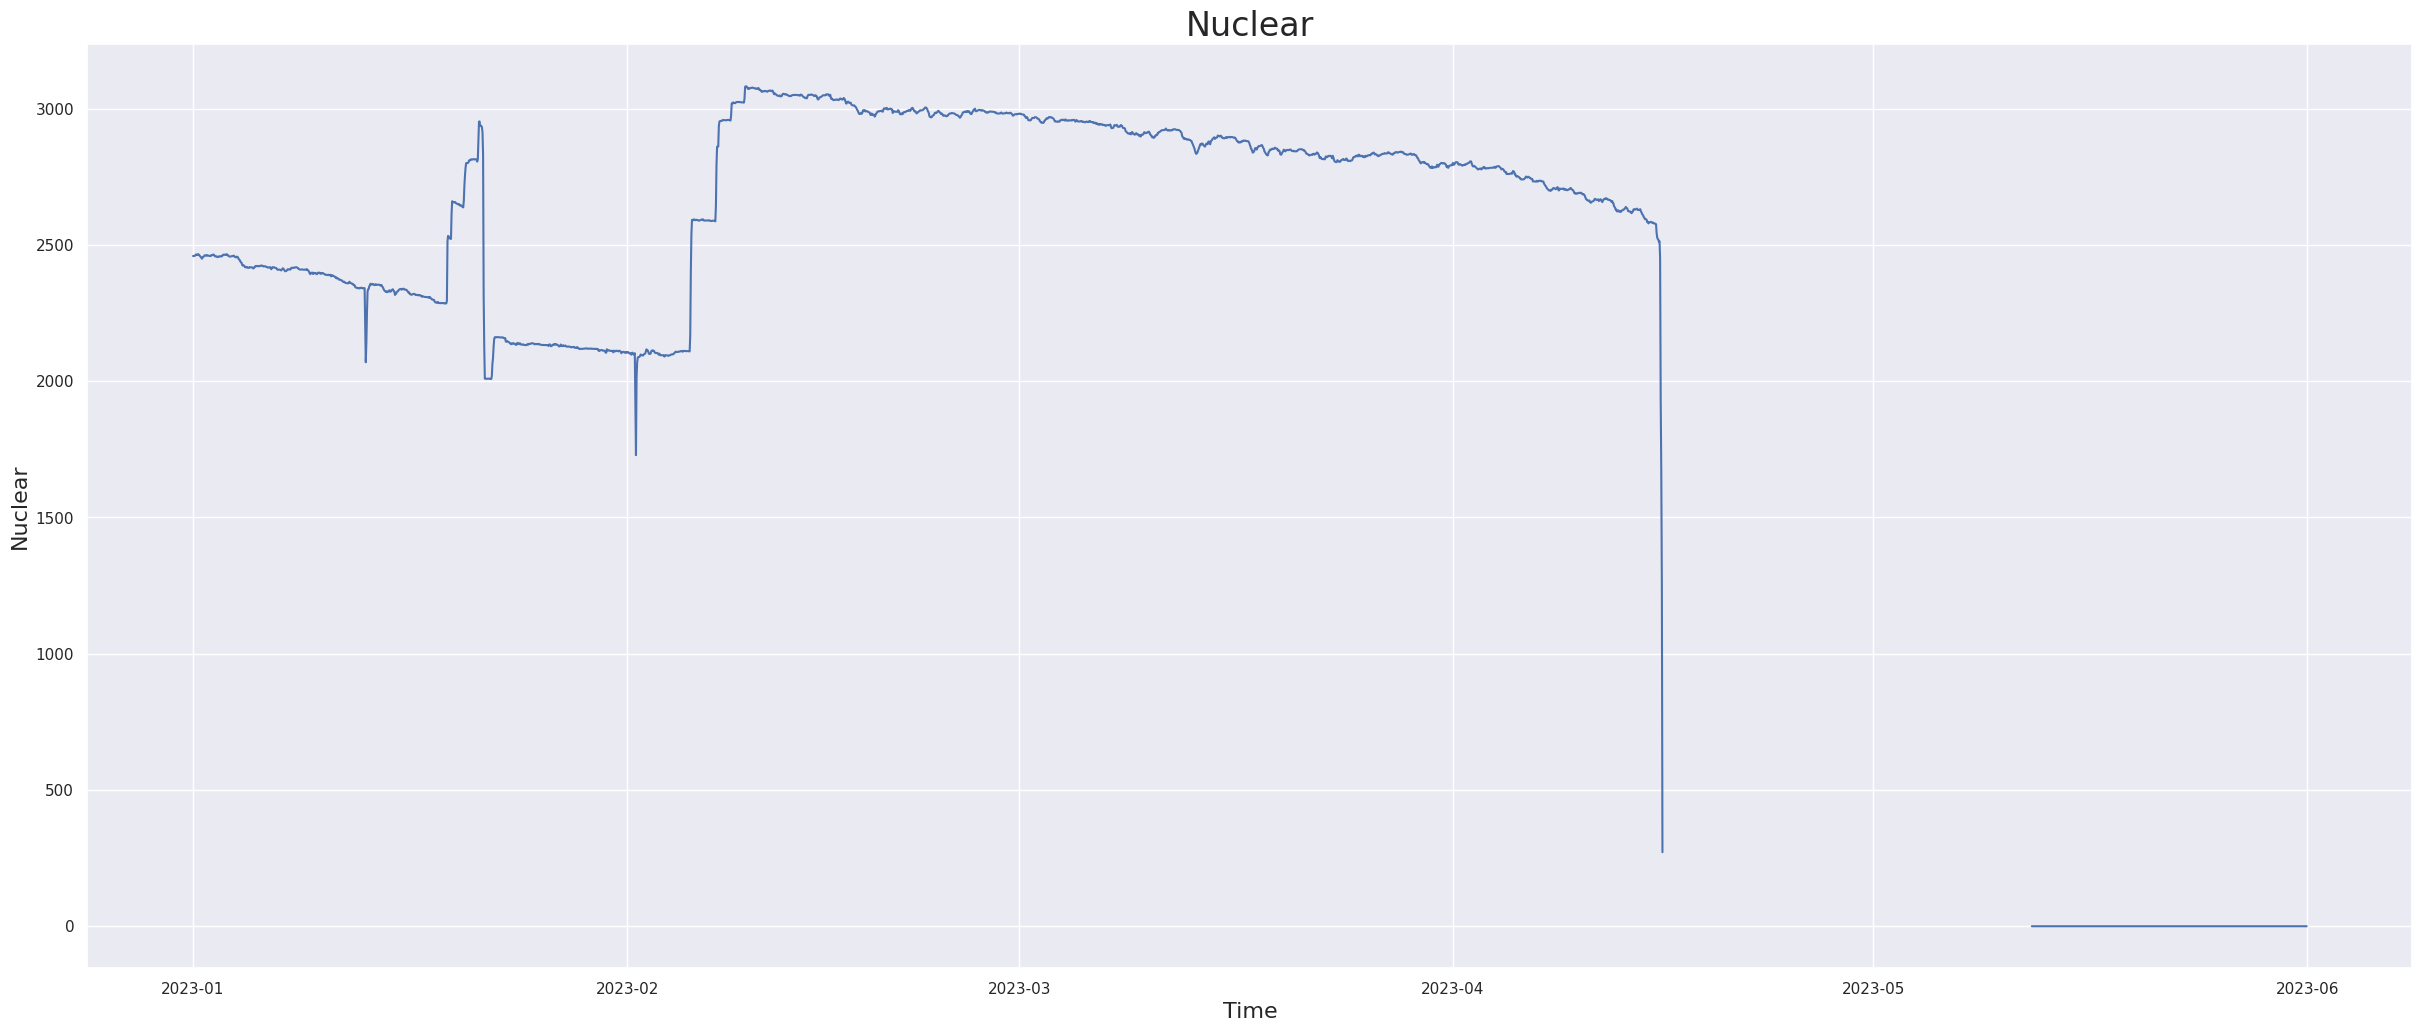

In [137]:
nuclear_col = ('Nuclear', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=nuclear_col, ylabel='Nuclear',
                 title='Nuclear')
plt.show()

As we can see the missin values are between mid of april and mid of may. On the other hand interestigly after the may it is always 0. So there is my shutdown in nuclear power plant in germany ? 
 * BINGO ! 
    * The last three nuclear power plants in Germany were shut down on 15 April 2023: Isar 2, Emsland and Neckarwestheim 2. Their shutdown had been planned for 31 December 2022. Due to the energy crisis, the three nuclear power plants continued operation in stretch-out mode until 15 April 2023 at the latest. ( https://www.base.bund.de/EN/ns/nuclear-phase-out/nuclear-phase-out_node.html#:~:text=The%20last%20three%20nuclear%20power%20plants%20in%20Germany%20were%20shut,April%202023%20at%20the%20latest.)

So now it make sense. We can just impute these values to 0 


In [138]:
df_energy[nuclear_col].fillna(0, inplace=True)

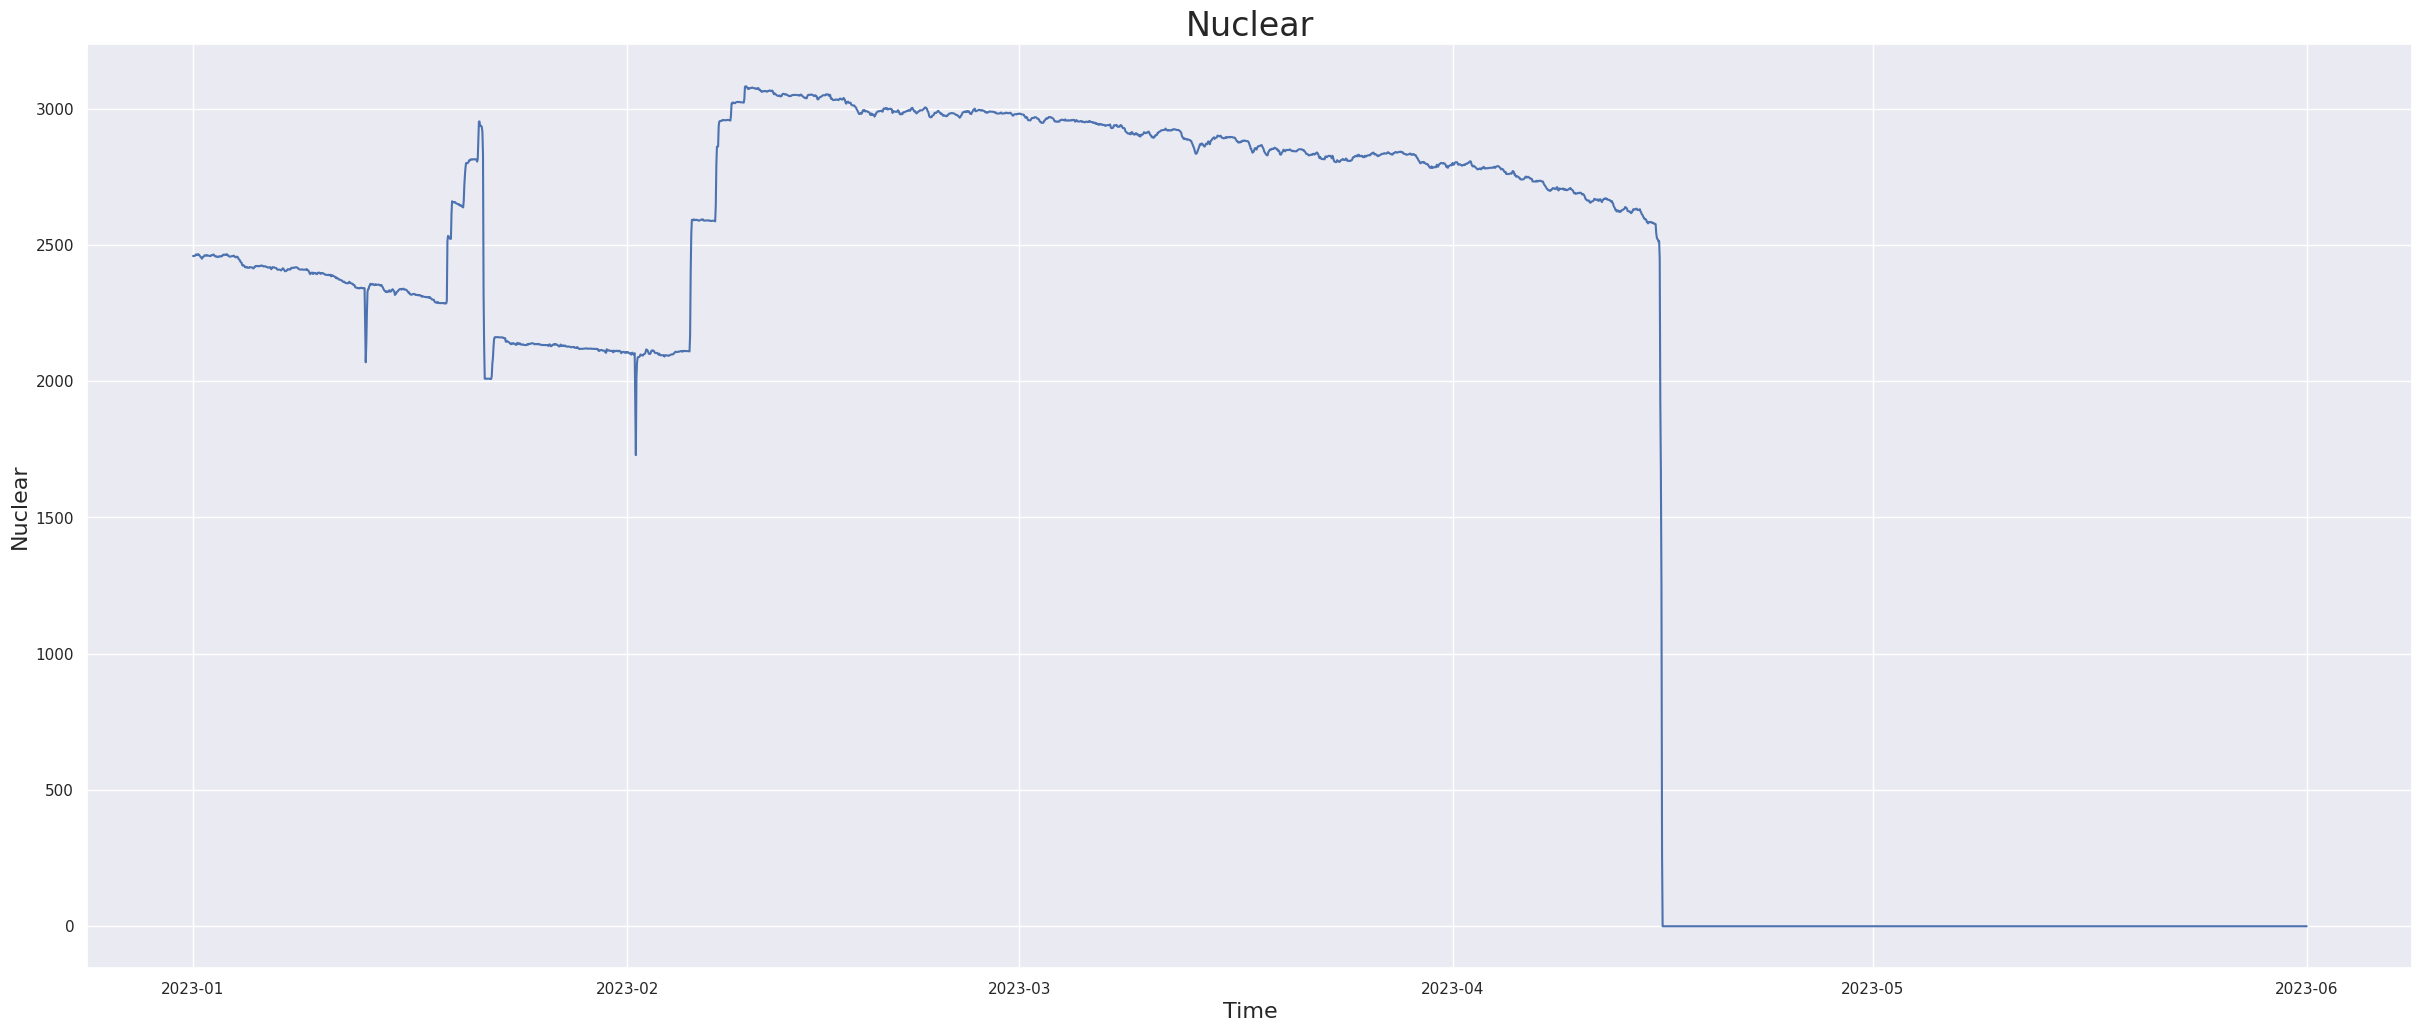

In [140]:
ax = plot_series(df=df_energy, column=nuclear_col, ylabel='Nuclear',
                 title='Nuclear')
plt.show()

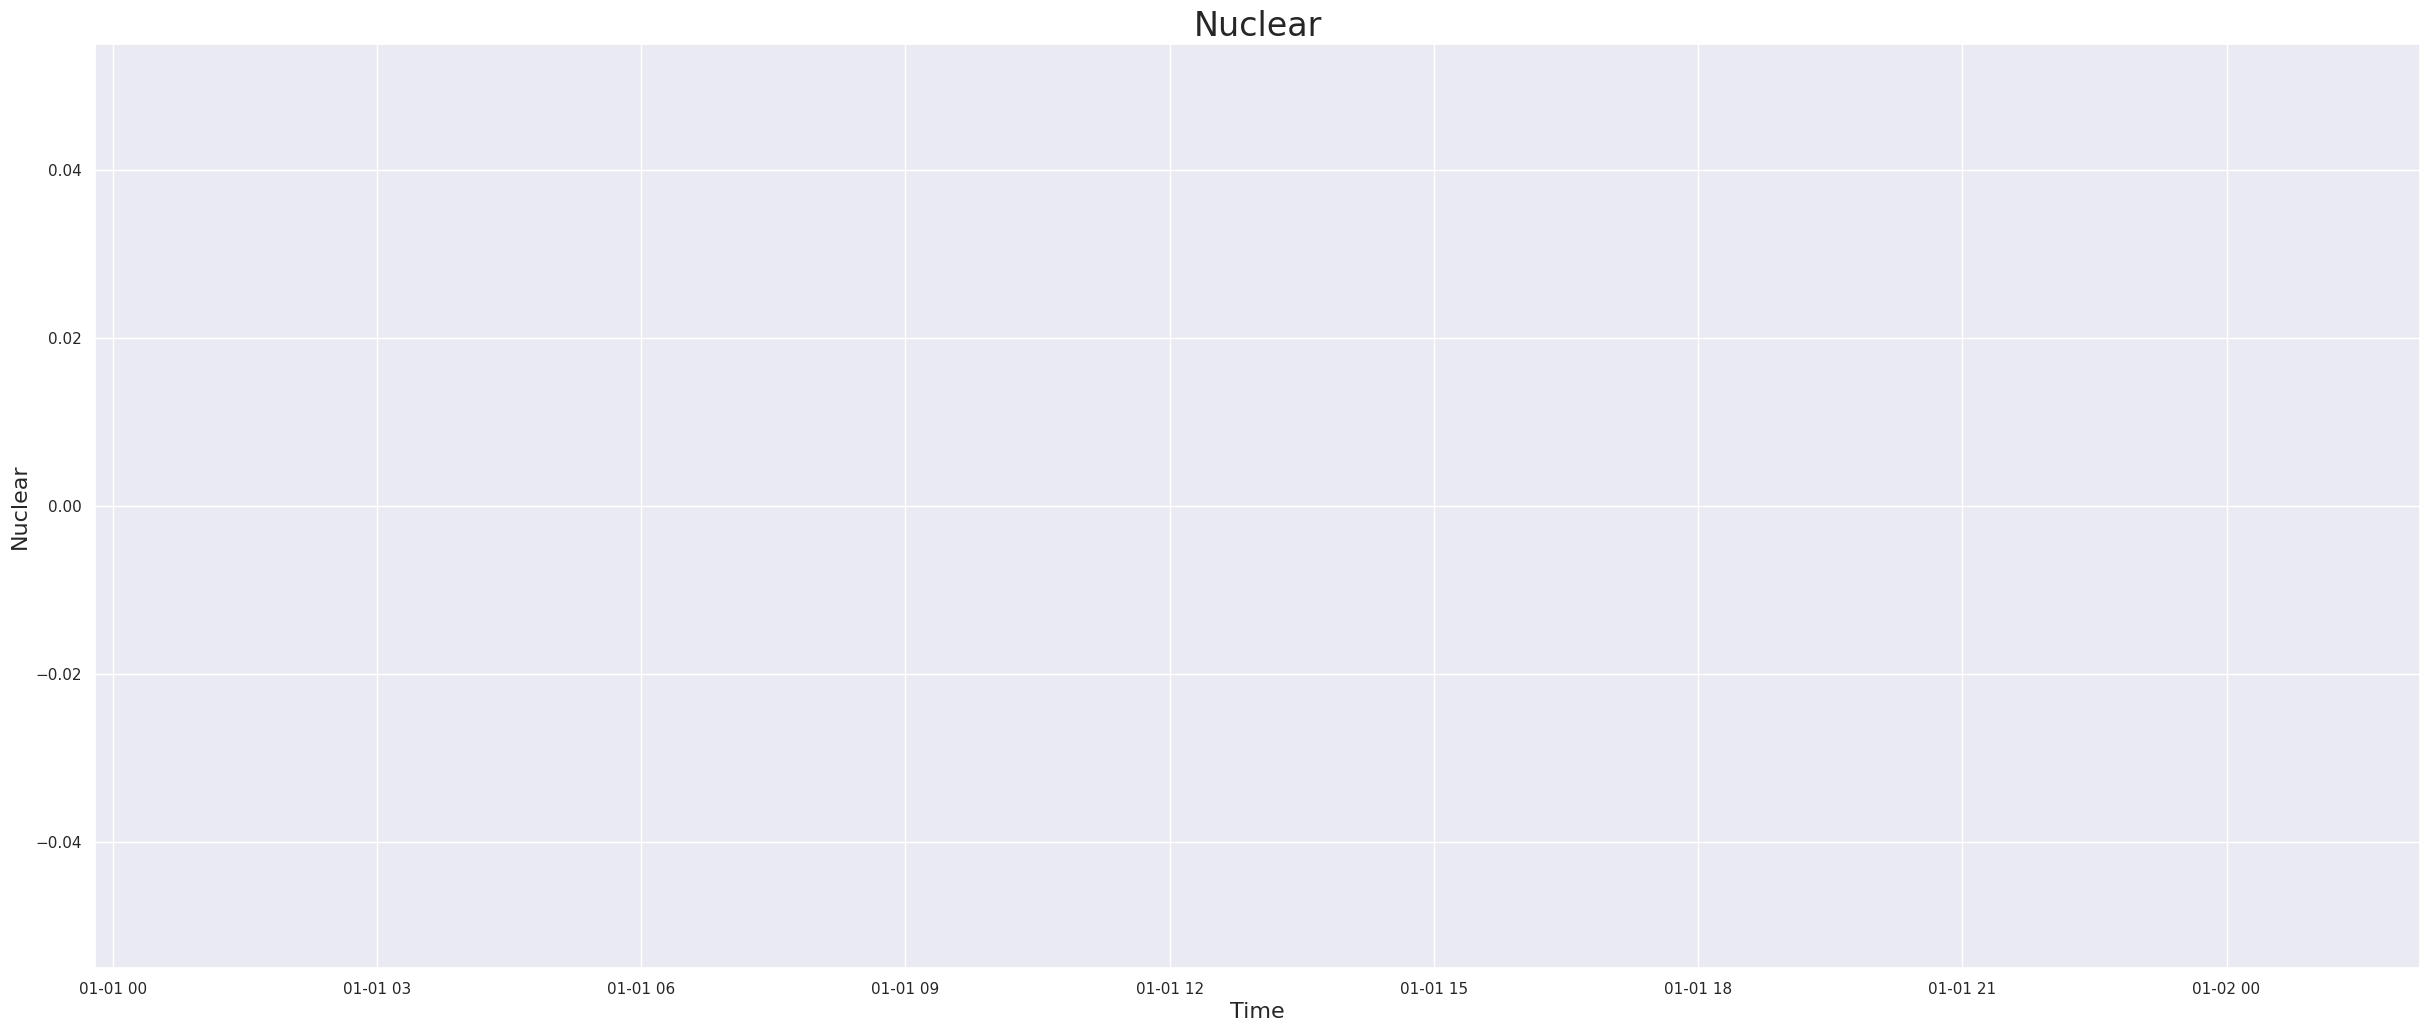

In [116]:
# Now lets have a look at the Biomass data
biomass_col = ('Biomass', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=biomass_col, ylabel='Nuclear',
                 title='Nuclear', end=24*12)
plt.show()

As you can see we do not have data for the first 13 days. Therefore it make sense get back data and use interpolation to fill thise values 

In [141]:
df_energy_all[biomass_col].interpolate(method='linear', limit_direction='backward', inplace=True, axis=0)

In [144]:
biomass_values = df_energy_all[biomass_col]
df_energy[biomass_col].fillna(biomass_values, inplace=True)

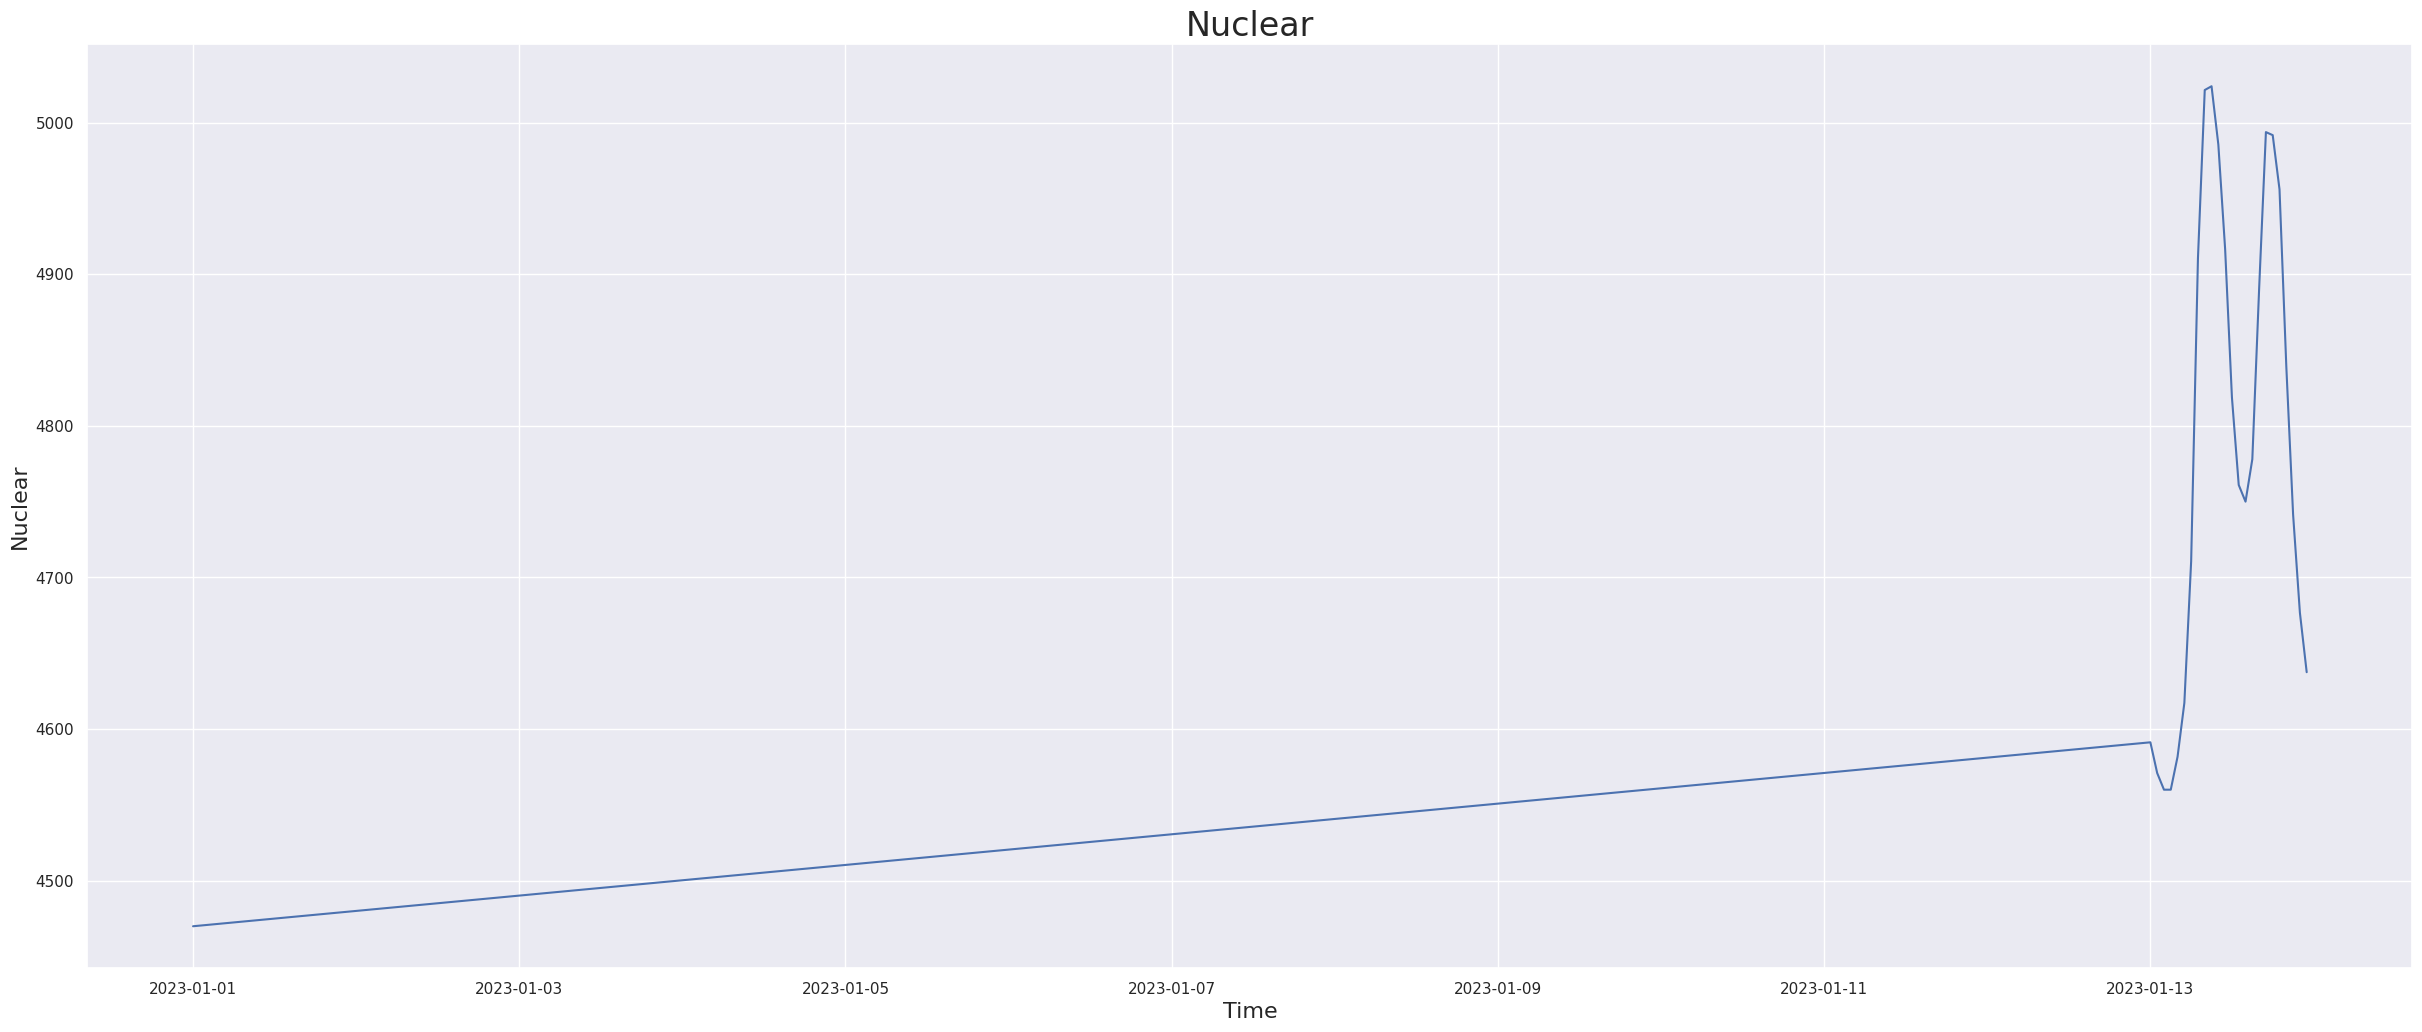

In [146]:
# Now lets have a look at the Biomass data
biomass_col = ('Biomass', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=biomass_col, ylabel='Nuclear',
                 title='Nuclear', end=24*13)
plt.show()

In [147]:
# Fill null values with the previous value
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [148]:
df_energy.isna().sum()

Actual Load                                             0
(Biomass, Actual Aggregated)                            0
(Fossil Brown coal/Lignite, Actual Aggregated)          0
(Fossil Gas, Actual Aggregated)                         0
(Fossil Hard coal, Actual Aggregated)                   0
(Fossil Oil, Actual Aggregated)                         0
(Geothermal, Actual Aggregated)                         0
(Hydro Pumped Storage, Actual Aggregated)               0
(Hydro Pumped Storage, Actual Consumption)              0
(Hydro Run-of-river and poundage, Actual Aggregated)    0
(Hydro Water Reservoir, Actual Aggregated)              0
(Nuclear, Actual Aggregated)                            0
(Other, Actual Aggregated)                              0
(Other renewable, Actual Aggregated)                    0
(Solar, Actual Aggregated)                              0
(Waste, Actual Aggregated)                              0
(Wind Offshore, Actual Aggregated)                      0
(Wind Onshore,

It look like df_energy has been cleaned successfully and is ready for further use as input into our model.

### Weather Dataset

In [175]:
df_weather_all = pd.concat([df_dict['weather_data']], axis=1)
start_date = '2023-01-01'
df_weather = df_weather_all[df_weather_all.index >= start_date]

In [176]:
df_weather.head()

,air_temperature_berlin,visibility_berlin,wind_speed_berlin,wind_direction_berlin,air_temperature_frankfurt,visibility_frankfurt,wind_speed_frankfurt,wind_direction_frankfurt,air_temperature_munich,visibility_munich,wind_speed_munich,wind_direction_munich
2023-01-01 00:00:00+01:00,16.1,16340.0,6.0,200.0,10.1,52510.0,12.3,220.0,15.3,27050.0,5.8,190.0
2023-01-01 01:00:00+01:00,16.1,59470.0,6.5,210.0,9.7,56060.0,11.6,230.0,15.0,53520.0,5.3,190.0
2023-01-01 02:00:00+01:00,15.4,53430.0,6.2,210.0,8.5,62460.0,10.7,220.0,14.5,60300.0,5.5,200.0
2023-01-01 03:00:00+01:00,15.1,61190.0,6.1,190.0,8.6,75000.0,11.8,220.0,14.9,63790.0,5.4,200.0
2023-01-01 04:00:00+01:00,15.4,72030.0,6.4,190.0,8.3,73380.0,11.4,220.0,14.9,64450.0,6.4,200.0
